# Time-Warped Autoregressive HMM (TWARHMM) Demo

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lindermanlab/ssm-jax-refactor/blob/main/notebooks/arhmm-example.ipynb)

This notebook illustrates the use of the _time-warped_ autoregressive HMM.  
Let $x_t$ denote the observation at time $t$. Let $z_t$ denote the corresponding discrete latent state and $\tau_t$ the latent time constant.

The time-warped autoregressive hidden Markov model has the following likelihood,
$$
\begin{align}
x_t - x_{t-1} \mid x_{t-1}, z_t &\sim
\mathcal{N}\left(\tau_t^{-1} (A_{z_t} x_{t-1} + b_{z_t}), \tau_t^{-1} Q_{z_t} \right).
\end{align}
$$
When the time constant is small, dynamics are faster. When the time constant is large, dynamics are slower.
Our goal is to infer the discrete latent states, their dynamics parameters, and the latent time-constants that modulate their speed.

Technically, the time-warped ARHMM is a special case of a _factorial_ HMM, since we model the time-constants as taking values in a discrete set and following a Markov transition model,
$$
\begin{align}
p(z_t, \tau_t \mid z_{t-1}, \tau_{t-1}) = p(z_t \mid z_{t-1}) \times p(\tau_t \mid \tau_{t-1})
\end{align}
$$

# Setup

In [1]:
try:
    import ssm
except:
    import os
    from getpass import getpass
    user = getpass('GitHub user')
    password = getpass('GitHub token')
    os.environ['GITHUB_AUTH'] = user + ':' + password
    !pip install git+https://$GITHUB_AUTH@github.com/lindermanlab/ssm-jax-refactor.git -qqq
    del user, password
    import ssm

In [2]:
import jax.numpy as np
import jax.random as jr

from tensorflow_probability.substrates import jax as tfp

from ssm.twarhmm import GaussianTWARHMM
from ssm.utils import random_rotation
from ssm.plots import gradient_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [3]:
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange",
    "brown",
    "pink"
    ]


colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

# Create the Components for our TWARHMM

### Transition matrix

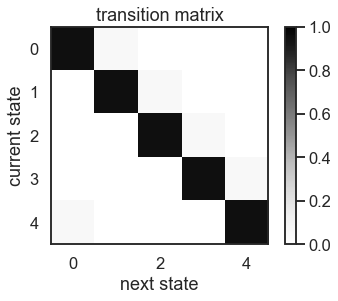

In [4]:
num_states = 5
transition_probs = (np.arange(num_states)**10).astype(float)
transition_probs /= transition_probs.sum()
transition_matrix = np.zeros((num_states, num_states))
for k, p in enumerate(transition_probs[::-1]):
    transition_matrix += np.roll(p * np.eye(num_states), k, axis=1)
    
plt.imshow(transition_matrix, vmin=0, vmax=1, cmap="Greys")
plt.xlabel("next state")
plt.ylabel("current state")
plt.title("transition matrix")
plt.colorbar()
plt.show()

### Observation distributions

In [6]:
data_dim = 2
num_lags = 1

keys = jr.split(jr.PRNGKey(0), num_states)
angles = np.linspace(0, 2 * np.pi, num_states, endpoint=False)
theta = np.pi / 25 # rotational frequency
weights = np.array([0.8 * random_rotation(key, data_dim, theta=theta) for key in keys])
biases = np.column_stack([np.cos(angles), np.sin(angles), np.zeros((num_states, data_dim - 2))])
covariances = np.tile(0.001 * np.eye(data_dim), (num_states, 1, 1))

# Compute the stationary points
stationary_points = np.linalg.solve(np.eye(data_dim) - weights, biases)

### Plot dynamics functions

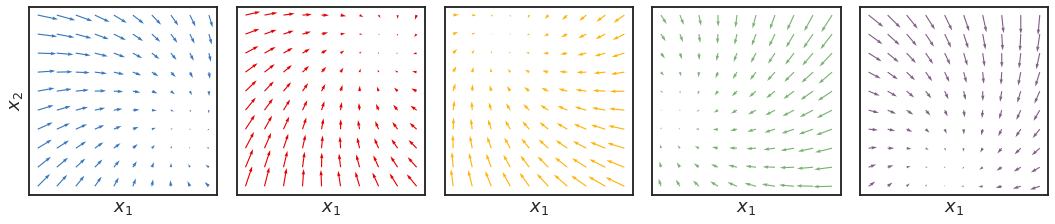

In [7]:
if data_dim == 2:
    lim = 5
    x = np.linspace(-lim, lim, 10)
    y = np.linspace(-lim, lim, 10)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    fig, axs = plt.subplots(1, num_states, figsize=(3 * num_states, 6))
    for k in range(num_states):
        A, b = weights[k], biases[k]
        dxydt_m = xy.dot(A.T) + b - xy
        axs[k].quiver(xy[:, 0], xy[:, 1],
                    dxydt_m[:, 0], dxydt_m[:, 1],
                    color=colors[k % len(colors)])

        
        axs[k].set_xlabel('$x_1$')
        axs[k].set_xticks([])
        if k == 0:
            axs[k].set_ylabel("$x_2$")
        axs[k].set_yticks([])
        axs[k].set_aspect("equal")
                        

    plt.tight_layout()

### Initialize time constants

In [8]:
time_constants = np.logspace(-1, 1, num=25, base=4)

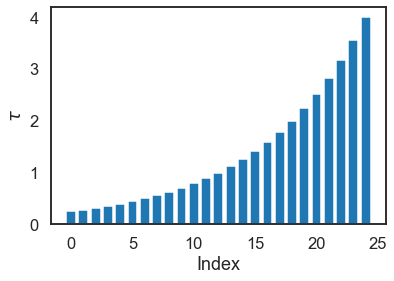

In [9]:
plt.bar(np.arange(25), time_constants)
plt.ylabel(r"$\tau$")
plt.xlabel("Index")
plt.show()

# Create a TWARHMM and sample data from it

In [10]:
# Make a Time-Warped Autoregressive (TWAR)HMM
true_twarhmm = GaussianTWARHMM(num_states, 
                               time_constants,
                               discrete_state_transition_matrix=transition_matrix,
                               emission_weights=weights - np.eye(data_dim),
                               emission_biases=biases,
                               emission_covariances=covariances)

In [11]:
time_bins = 10000
true_states, data = true_twarhmm.sample(jr.PRNGKey(0), time_bins)

# states are "factored" into the hidden state $z_t$ and the time constant $/tau_t$
true_states, true_time_constants = true_states

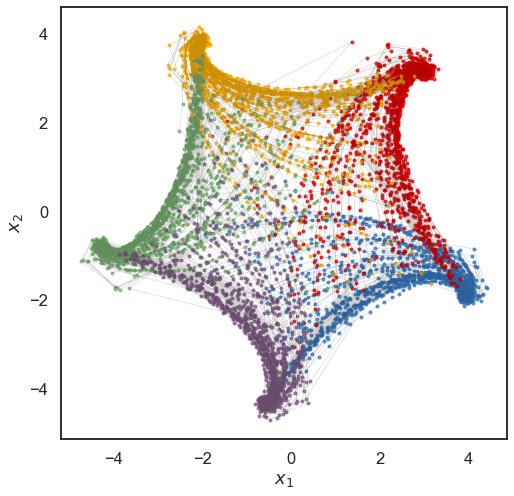

In [12]:
# Plot the emissions colored by state
fig = plt.figure(figsize=(8, 8))
slc = slice(0, min(time_bins, 10000))
for k in range(num_states):
    plt.plot(*data[slc][true_states[slc]==k].T, 'o', color=colors[k % len(colors)],
         alpha=0.75, markersize=3)
    
plt.plot(*data[slc].T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.gca().set_aspect("equal")
plt.show()

Below, we visualize the observation and latent variables. The top plot shows the latent time constants as a time series, with a dotted line at $\tau_t=1$. The bottom plot shows each component of of the observation variable as a time series. The colors correspond to the latent state $z_t$. The dotted lines represent the stationary point of the the corresponding AR state while the solid lines are the actual observations sampled from the HMM.

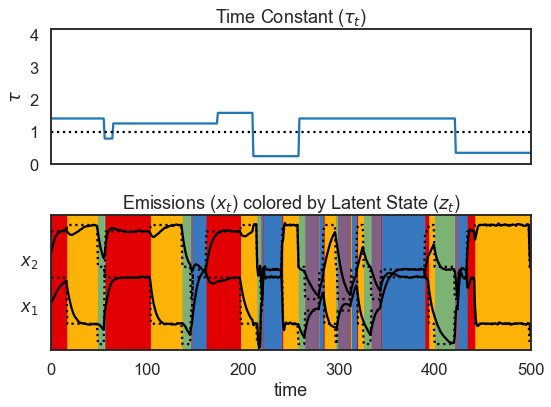

In [13]:
# Plot the data and the smoothed data
plot_slice = (0, 500)
lim = 1.05 * abs(data).max()
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)

axs[0].set_title("Time Constant ($\\tau_t$)")
axs[0].set_ylabel("$\\tau$")
axs[0].plot(time_constants[true_time_constants])
axs[0].plot(np.ones_like(true_time_constants), ':k')
axs[0].set_yticks(np.arange(0, 5, 1))
axs[1].imshow(true_states[None, :],
           aspect="auto",
           cmap=cmap,
           vmin=0,
           vmax=len(colors)-1,
           extent=(0, time_bins, -lim, (data_dim)*lim))


Ey = np.array(stationary_points)[true_states]
for d in range(data_dim):
    axs[1].plot(data[:,d] + lim * d, '-k')
    axs[1].plot(Ey[:,d] + lim * d, ':k')

axs[1].set_title("Emissions ($x_t$) colored by Latent State ($z_t$)")
axs[1].set_xlim(plot_slice)
axs[1].set_xlabel("time")
axs[1].set_yticks(lim * np.arange(data_dim))
axs[1].set_yticklabels(["$x_{{{}}}$".format(d+1) for d in range(data_dim)])

plt.tight_layout()
plt.show()

# Fit a TWARHMM

In [14]:
from ssm.twarhmm import GaussianTWARHMM

In [15]:
# Now fit an TWHMM to the data
key1, key2 = jr.split(jr.PRNGKey(0), 2)
test_num_states = num_states

# Initialize unspecified component randomly
twarhmm = GaussianTWARHMM(test_num_states, 
                          time_constants,
                          data_dim,
                          seed=jr.PRNGKey(0))

In [16]:
data.shape[:2]

(10000, 2)

In [17]:
lps, twarhmm, posteriors = twarhmm.fit(data)

Initializing...
Done.


  0%|          | 0/100 [00:00<?, ?it/s]

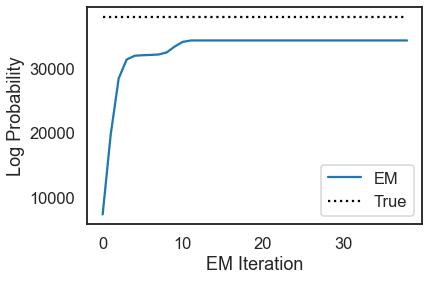

In [18]:
# Plot the log likelihoods against the true likelihood, for comparison
true_lp = true_twarhmm.marginal_likelihood(data)
plt.plot(lps, label="EM")
plt.plot(true_lp * np.ones(len(lps)), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

In [19]:
expected_discrete_states = posteriors.expected_states[0].sum(axis=2)
prob_time_constants = posteriors.expected_states[0].sum(axis=1)
expected_time_constants = np.einsum('...i,i->...', prob_time_constants, time_constants)

In [20]:
from ssm.utils import find_permutation
perm = find_permutation(np.argmax(expected_discrete_states, axis=1), true_states)

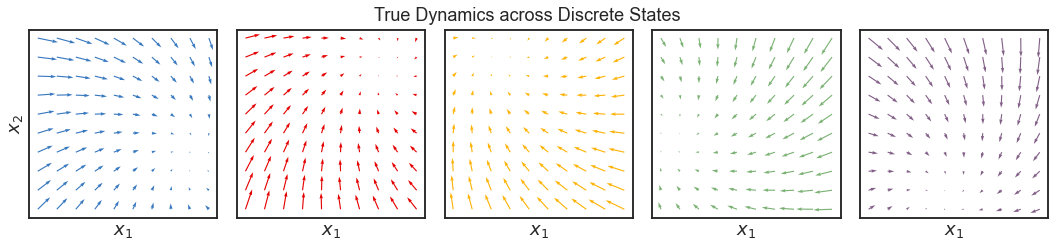

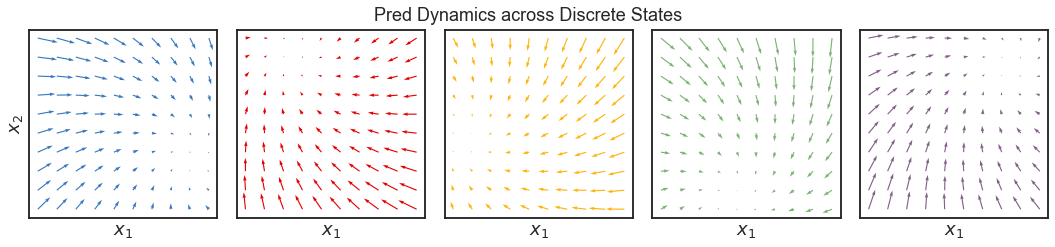

In [21]:
if data_dim == 2:
    lim = abs(data).max()
    x = np.linspace(-lim, lim, 10)
    y = np.linspace(-lim, lim, 10)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    for i, model in enumerate([true_twarhmm, twarhmm]):
        fig, axs = plt.subplots(1, max(num_states, test_num_states), figsize=(3 * num_states, 6))
        plt.figtext(0.5, 0.75, ["True Dynamics across Discrete States", 
                                "Pred Dynamics across Discrete States"][i],
                    ha='center', va='center')
        for j in range(model.num_discrete_states):
            j = perm[j]
            dist = model._emissions
            A, b = dist._weights[j] + np.eye(data_dim), dist._biases[j]
            dxydt_m = xy.dot(A.T) + b - xy
            axs[j].quiver(xy[:, 0], xy[:, 1],
                        dxydt_m[:, 0], dxydt_m[:, 1],
                        color=colors[j % len(colors)])


            axs[j].set_xlabel('$x_1$')
            axs[j].set_xticks([])
            if j == 0:
                axs[j].set_ylabel("$x_2$")
            axs[j].set_yticks([])
            axs[j].set_aspect("equal")   
        plt.tight_layout()

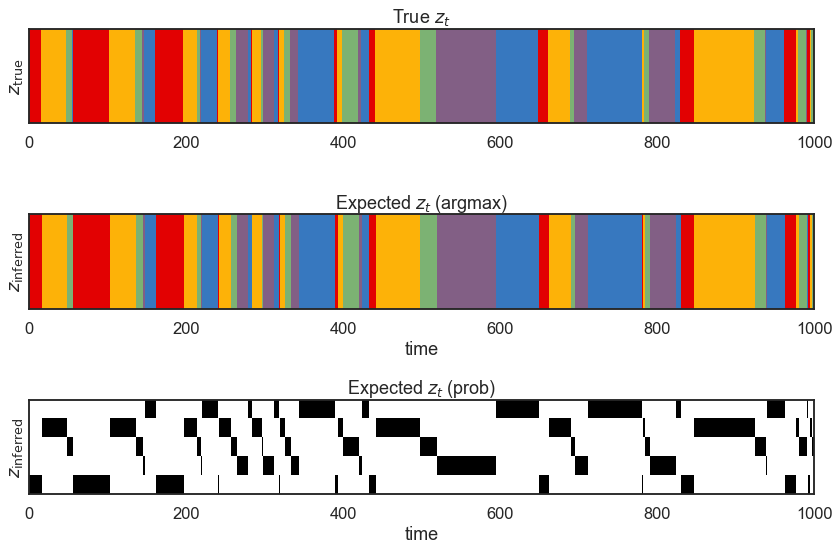

In [22]:
# Plot the true and inferred discrete states
plot_slice = (0, 1000)
plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.imshow(true_states[None,num_lags:], aspect="auto", interpolation="none", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])
plt.title("True $z_t$")

plt.subplot(312)
plt.imshow(perm[np.argmax(expected_discrete_states, axis=1)][None, :], aspect="auto", interpolation="none", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")
plt.title("Expected $z_t$ (argmax)")

plt.subplot(313)
# plt.imshow(expected_discrete_states[None,: :], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.imshow(expected_discrete_states.T, aspect="auto", interpolation="none", cmap="Greys", vmin=0, vmax=1)
plt.xlim(plot_slice)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")
plt.title("Expected $z_t$ (prob)")

plt.tight_layout()

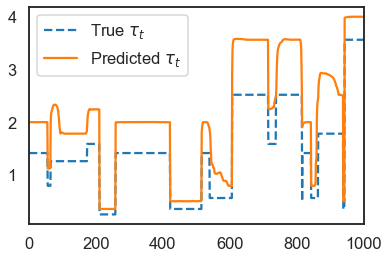

In [23]:
# Plot the true and expected time constants for a slice of the data
plt.plot(time_constants[true_time_constants], '--', label="True $\\tau_t$")
plt.plot(expected_time_constants, label="Predicted $\\tau_t$")
plt.xlim(0, 1000)
plt.legend()
plt.show()

# Sample the fitted model and see what it looks like

In [24]:
# Sample the fitted model
sampled_states, sampled_data = twarhmm.sample(jr.PRNGKey(0), time_bins)

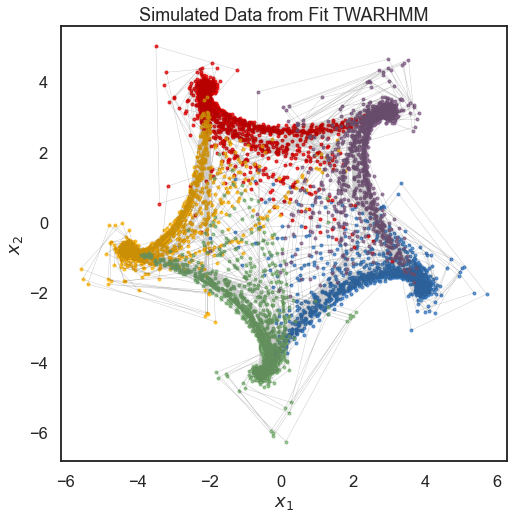

In [25]:
fig = plt.figure(figsize=(8, 8))
slc = slice(0, min(time_bins, 10000))
for k in range(num_states):
    plt.plot(*sampled_data[slc][sampled_states[0][slc]==k].T, 'o', color=colors[k],
         alpha=0.75, markersize=3)
    
plt.title("Simulated Data from Fit TWARHMM")
plt.plot(*sampled_data[slc].T, '-k', lw=0.5, alpha=0.2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()